In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt

# Utilities and analysis setup

In [2]:
# dict to map node ID to node address
node_map = {
    '1': 'planetlab2.citadel.edu',
    '2': 'planetlab2.c3sl.ufpr.br',
    '3': 'planetlab6.goto.info.waseda.ac.jp',
    '4': 'pl-dccd-01.cua.uam.mx',
    '5': 'planetlab3.rutgers.edu',
    '6': 'planetlab2.ie.cuhk.edu.hk',
    '7': 'planetlab1.temple.edu',
    '8': 'planetlab1.rutgers.edu'
}

node_loc = {
    '1': 'US (Citadel)',
    '2': 'Brazil',
    '3': 'Japan',
    '4': 'Mexico',
    '5': 'US (Rutgers 3)',
    '6': 'Hong Kong',
    '7': 'US (Temple)',
    '8': 'US (Rutgers 1)'
}

node_pairs = {
    '1-2 & 2-1': f"{node_loc['1']} ⟷ {node_loc['2']}",
    '1-5 & 5-1': f"{node_loc['1']} ⟷ {node_loc['5']}",
    '3-5 & 5-3': f"{node_loc['3']} ⟷ {node_loc['5']}",
    '4-7 & 7-4': f"{node_loc['4']} ⟷ {node_loc['7']}",
    '6-8 & 8-6': f"{node_loc['6']} ⟷ {node_loc['8']}",
}

### Set the current working directory to the project root

In [3]:
os.chdir("/Users/jlahut/UAlbany/comp-comm-networks/final-project/project/")

### Read in data files
Data files have the following format `<type>_<src>-<dest>_<Y-M-D>_<H-M-S>`  
*The timestamps in the file names are local to the node in which it came from*

In [4]:
data = []
print(f"Reading in {len(os.listdir('data/'))} files...")
for filename in os.listdir("data/"):
    try:
        items = filename.split('_')

        measure = items[0]
        src, dest = items[1].split('-')

        date = items[2]
        time = items[3].split('.')[0]

        timestamp = dt.datetime.strptime(f'{date} {time}', '%Y-%m-%d %H-%M-%S')
        content = ''

        with open(os.path.join('data', filename), 'r') as file:
            content = file.read()
            
        if (src == '1' and dest == '2') or (src == '2' and dest == '1'):
            pair = '1-2 & 2-1'
        elif (src == '3' and dest == '5') or (src == '5' and dest == '3'):
            pair = '3-5 & 5-3'
        elif (src == '4' and dest == '7') or (src == '7' and dest == '4'):
            pair = '4-7 & 7-4'
        elif (src == '6' and dest == '8') or (src == '8' and dest == '6'):
            pair = '6-8 & 8-6'
        elif (src == '1' and dest == '5') or (src == '5' and dest == '1'):
            pair = '1-5 & 5-1'
        else:
            pair = 'Error'

        data.append([src, dest, timestamp, measure, node_map[src], node_map[dest], content, filename, pair])
    except:
        print(f'Could not read file: {filename}')

Reading in 14654 files...
Could not read file: traceroute_-_2019-11-21_01-36-28.txt


### Create 'master' dataframe to hold all raw data

In [5]:
df = pd.DataFrame(data, columns = ['src_id', 'dest_id', 'time', 'measure', 'src_name', 'dest_name', 'raw_data', 'filename', 'pair'])

### Ping and Traceroute functions to be applied accross the dataframe
- Used mainly for file parsing


In [6]:
# example format
# rtt min/avg/max/mdev = 68.244/68.337/68.498/0.129 ms or
# rtt min/avg/max/mdev = 68.244/68.337/68.498/0.129 ms, pipe n
# 20 packets transmitted, 20 received, 0% packet loss, time 19029ms
def analyze_ping(data):
    
    # only worries about ping
    if (data['measure'] != 'ping'):
        return data
    
    try:
        # --- parse out statistics ---
        # second to last line will always be calculated values
        # split on '=' sign, then strip all spaces, remove units, and finally split on '/'
        # giving the values we need
        metrics = data['raw_data'].split('\n')[-2].split('=')[1].strip().replace(' ms', '').split(',')[0].split('/')
        data['min_ping_time'], data['avg_ping_time'], data['max_ping_time'], data['sd_ping_time'] = \
            float(metrics[0]), float(metrics[1]), float(metrics[2]), float(metrics[3])
    except Exception as e:
        print(f"No calculated data for: {data['filename']} [stats]")
        
    try:
         
        # --- parse out packet loss ---
        # third to last line will always be the line with packet loss
        data['packet_loss'] = float(data['raw_data'].split('\n')[-3].split(',')[2].split(' ')[1].replace('%', ''))
    except Exception as e:
        print(f"No calculated data for: {data['filename']} [packetloss]")
    return data

def analyze_traceroute(data):
    
    from pprint import pprint
    
    # only worried about traceroute
    if data['measure'] != 'traceroute':
        return data
    
    try:
        traceroute = [x.strip() for x in data['raw_data'].split('\n')]
        routers = [x.split('  ')[1] for x in traceroute if len(x.split('  ')) > 1]
        ip_addresses = [x.split(' ')[1].replace('(', '').replace(')', '') for x in routers]
        
        data['num_hops'] = len(routers)
        data['ips'] = ip_addresses
        
        
        
    except Exception as e:
        print(f"No calculated data for {data['filename']} {e}")
        
        
    return data

### Apply the functions

In [7]:
df = df.apply(analyze_ping, axis = 1)
df = df.apply(analyze_traceroute, axis = 1)

No calculated data for: ping_7-4_2019-12-04_03-09-44.txt [stats]
No calculated data for: ping_7-4_2019-12-05_04-26-39.txt [stats]
No calculated data for: ping_5-1_2019-12-03_20-02-13.txt [stats]
No calculated data for: ping_5-1_2019-12-03_20-02-13.txt [packetloss]
No calculated data for: ping_7-4_2019-12-04_01-07-00.txt [stats]
No calculated data for: ping_5-3_2019-11-28_20-26-34.txt [stats]
No calculated data for: ping_5-3_2019-11-28_20-26-34.txt [packetloss]
No calculated data for: ping_7-4_2019-11-27_03-21-14.txt [stats]
No calculated data for: ping_5-3_2019-12-03_18-42-14.txt [stats]
No calculated data for: ping_5-3_2019-12-03_18-42-14.txt [packetloss]
No calculated data for: ping_5-1_2019-12-03_19-32-03.txt [stats]
No calculated data for: ping_5-1_2019-12-03_19-32-03.txt [packetloss]
No calculated data for: ping_3-5_2019-12-04_22-29-20.txt [stats]
No calculated data for: ping_3-5_2019-12-04_22-29-20.txt [packetloss]
No calculated data for: ping_8-6_2019-11-25_18-34-59.txt [stats]


In [8]:
df[df['filename'] == 'ping_7-4_2019-12-04_03-09-44.txt']['raw_data'].tolist()

['PING pl-dccd-01.cua.uam.mx (148.206.185.33) 56(84) bytes of data.\n\n--- pl-dccd-01.cua.uam.mx ping statistics ---\n20 packets transmitted, 0 received, 100% packet loss, time 18999ms\n\n']

### Plotting average ping times for nodes

/Users/jlahut/UAlbany/comp-comm-networks/final-project/project/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


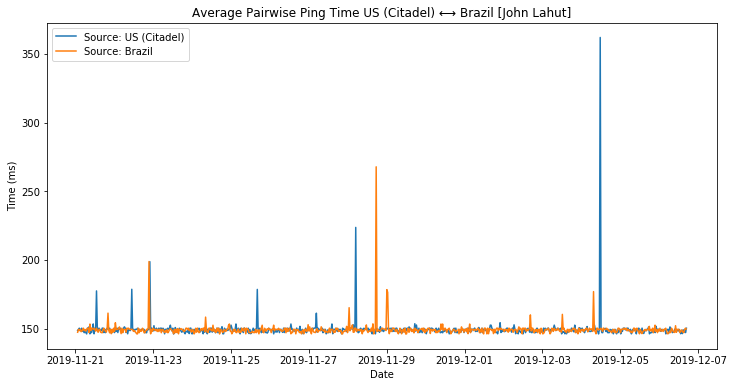

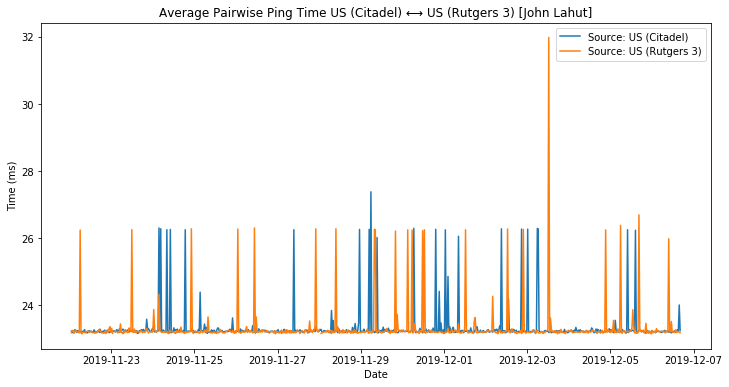

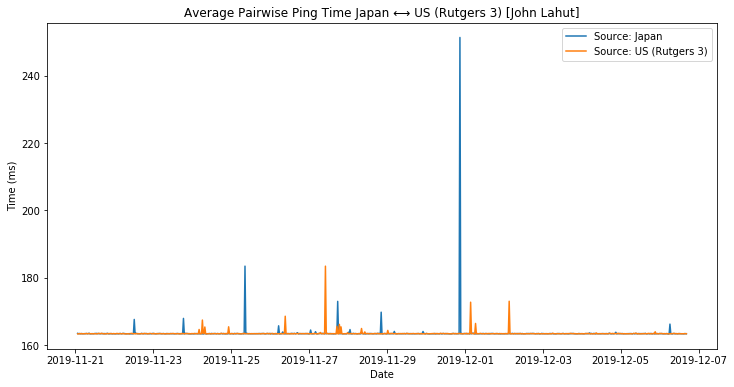

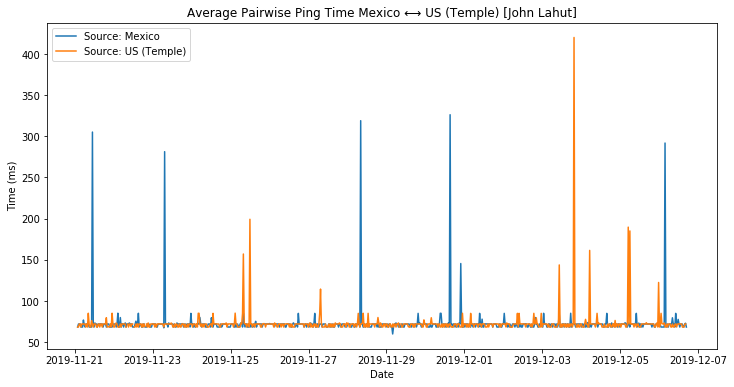

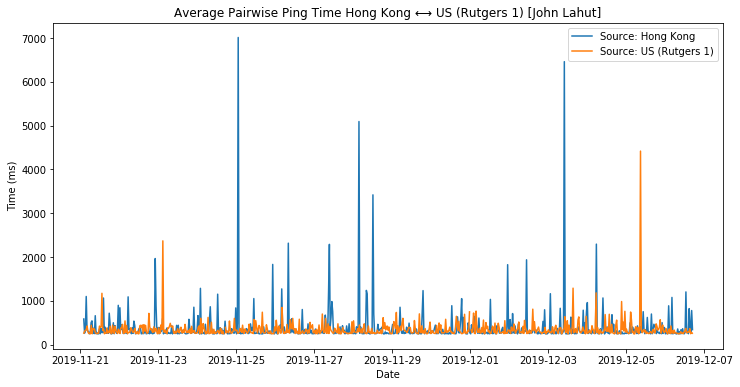

In [9]:
 for title, group in df[df['measure'] == 'ping'].groupby(['pair']):
    fig, ax = plt.subplots(figsize=(12, 6))
    legend = []
    
    
    
    for t, g in group.groupby(['src_id']):
        plt.plot(g['time'].sort_values(), g['avg_ping_time'])
        legend.append(f'Source: {node_loc[t]}')
        
    ax.legend(legend)
    ax.set_xlabel('Date')
    ax.set_ylabel('Time (ms)')
    ax.set_title(f'Average Pairwise Ping Time {node_pairs[title]} [John Lahut]')
    

### Plotting number of hops for each pair

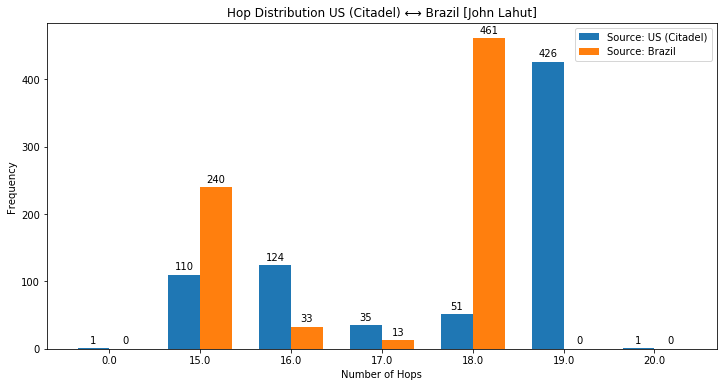

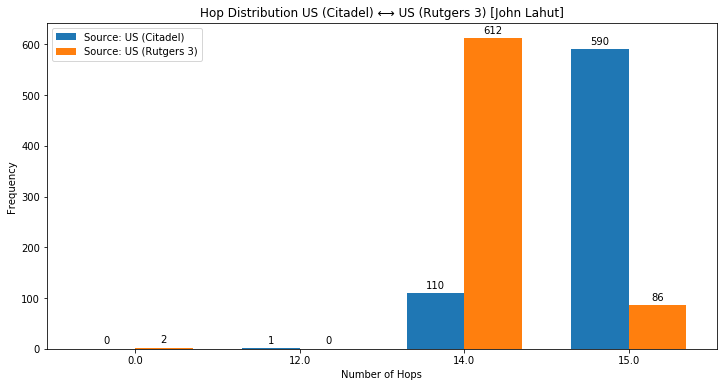

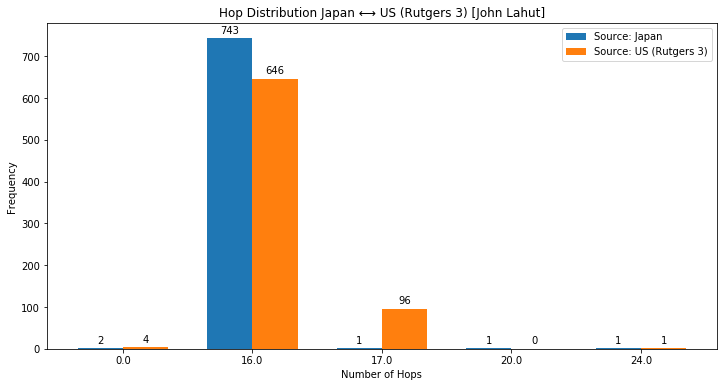

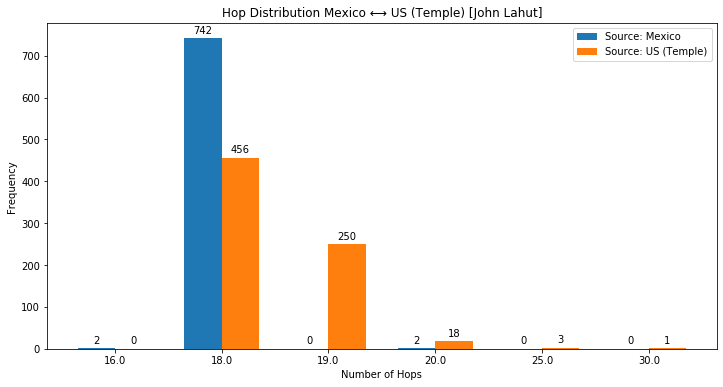

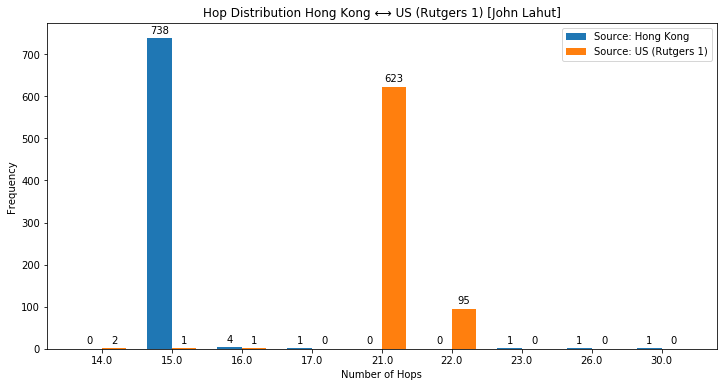

In [10]:
for title, group in df[df['measure'] == 'traceroute'].groupby(['pair']):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    hop_values = group['num_hops'].unique().tolist()
    hop_values.sort()
    width = 0.35
    
    rect1 = None
    rect2 = None
    x_labels = []
    for i, (t, g) in enumerate(group.groupby(['src_id'])):
        counters = {k:0 for k in hop_values}
        x = np.arange(len(counters.keys()))
        for k in counters.keys():
            if k not in x_labels:
                x_labels.append(k)
        for row in g['num_hops']:
            counters[row] += 1
        if i == 0:
            rect1 = ax.bar(x - width / 2, counters.values(), width, label = f'Source: {node_loc[t]}')
        else:
            rect2 = ax.bar(x + width / 2, counters.values(), width, label = f'Source: {node_loc[t]}')
            
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rect1)
    autolabel(rect2)
    ax.legend()
    ax.set_xlabel('Number of Hops')
    ax.set_ylabel('Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_title(f'Hop Distribution {node_pairs[set(group["pair"].values).pop()]} [John Lahut]')

### High level results of experiment

Ping timing statistics

|                        | US (Citadel) to Brazil | US (Citadel) to US (Rutgers 3) | Japan to US (Rutgers 3) | Mexico to US (Temple) | Hong Kong to US (Rutgers 1) |
| ---------------------- | :--------------------: | :----------------------------: | :---------------------: | :-------------------: | :-------------------------: |
| **Minimum ping time**  |        149.011         |             23.237             |         163.377         |        71.734         |           256.876           |
| **Average ping time**  |        149.284         |             23.338             |         163.529         |        72.768         |           368.329           |
| **Max ping time**      |        149.970         |             23.744             |         164.266         |        75.229         |           777.954           |
| **Standard deviation** |         0.516          |             0.214              |          0.502          |         1.167         |           140.994           |

In [11]:
def calc_gaps(group):
    
    # sort on time, shift column down, subtract the two for gap value
    group = group.assign(gaptime=group.sort_values(
        by=['time'])['time'] - group.sort_values(by=['time']).shift()['time'])
    
    # sort on time, shift column down, add a boolean if it exceeds the threshold
    group = group.assign(gap=group.sort_values(
        by=['time'])['time'] - group.sort_values(by=['time']).shift()['time'] > dt.timedelta(minutes=59))
   
    return group

# calculate the gaps for each node
df = df.groupby(['src_id', 'dest_id']).apply(calc_gaps)
# reset the indicies from the groupby function. columns will be grouped on both 'src_id' and 'dest_id',
# so drop them
df = df.reset_index(level=0, drop=True).reset_index(level=0, drop=True).reset_index().drop(columns=['index'])

# for title, group in df.groupby(['pair']):
    
#     print(f'---- Statistics for {title} ----')
#     print(f"{node_loc[title.split('-')[0]]} to {node_loc[title.split('-')[1].split(' ')[0]]}")
    
#     print(f'Mean minimum ping time: {group["min_ping_time"].describe()["mean"]}')
#     print(f'Mean average ping time: {group["avg_ping_time"].describe()["mean"]}')
#     print(f'Mean max ping time: {group["max_ping_time"].describe()["mean"]}')
#     print(f'Mean sd ping time: {group["sd_ping_time"].describe()["mean"]}')
#     print()

### Calculate CDF for packet loss and latency

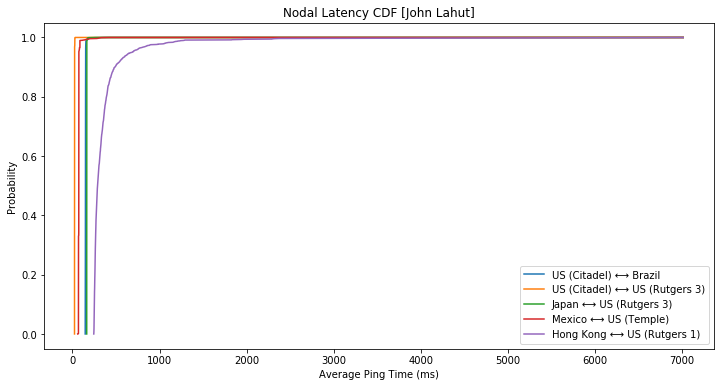

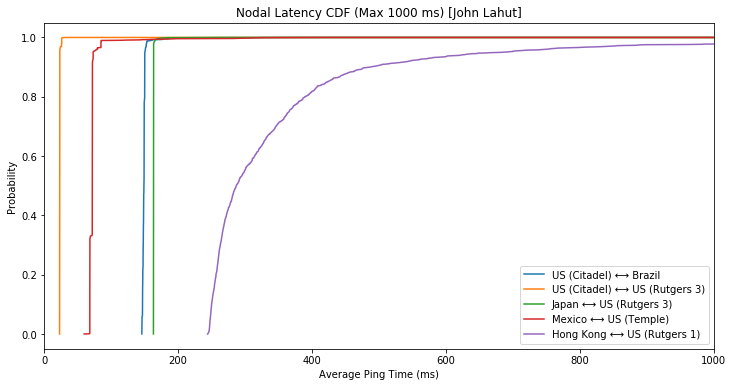

In [12]:
for i in range(2):
    # first group by each src, desc pair
    fig, ax = plt.subplots(figsize=(12, 6))
    legend = []
    
    if i == 1:
        ax.set_xlim(0, 1000)
    
    for title, group in df[df['measure'] == 'ping'].groupby(['pair']):

        # then group by the avg_ping_time
        stats_df = group.groupby('avg_ping_time')['avg_ping_time'].agg('count').pipe(pd.DataFrame).rename(
            columns = {'avg_ping_time': 'frequency'})

        # probability that the current time occurs
        stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
        # cumulative probability
        stats_df['cdf'] = stats_df['pdf'].cumsum()
        stats_df = stats_df.reset_index()

        # add the max value to each plot so that the CDF lines continue to end
        plt.plot(stats_df['avg_ping_time'].tolist()+[df['avg_ping_time'].max()],stats_df['cdf'].tolist()+[1])
        legend.append(node_pairs[title])
        
    if i == 0:
        ax.set_title('Nodal Latency CDF [John Lahut]')
    else:
        ax.set_title('Nodal Latency CDF (Max 1000 ms) [John Lahut]')
    ax.set_xlabel('Average Ping Time (ms)')
    ax.set_ylabel('Probability')
    ax.legend(legend)

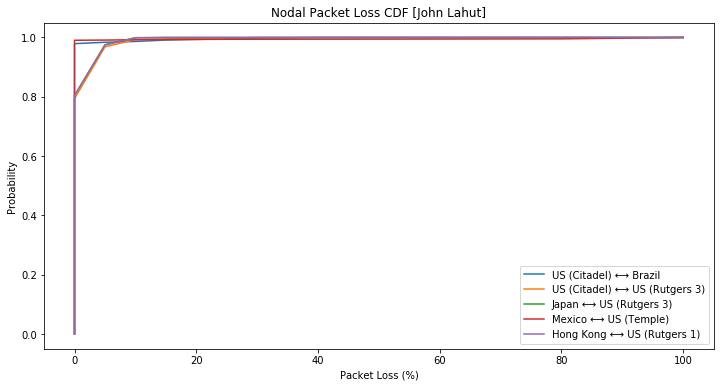

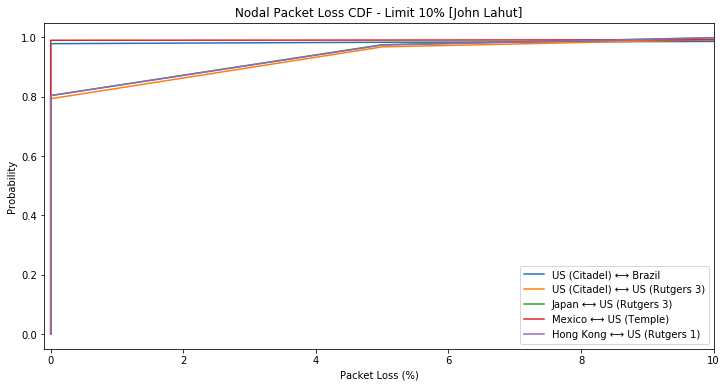

In [13]:
# first group by each src, desc pair
for i in range(2):
    fig, ax = plt.subplots(figsize=(12, 6))
    legend = []
    for title, group in df[df['measure'] == 'ping'].groupby(['pair']):

        # then group by the packet_loss
        stats_df = group.groupby('packet_loss')['packet_loss'].agg('count').pipe(pd.DataFrame).rename(
            columns = {'packet_loss': 'frequency'})
        
        

        # probability that the current time occurs
        stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
        # cumulative probability
        stats_df['cdf'] = stats_df['pdf'].cumsum()
        stats_df = stats_df.reset_index()
        
        # add the max value to each plot so that the CDF lines continue to end
        plt.plot([0] + stats_df['packet_loss'].tolist() + [df['packet_loss'].max()], 
                 [0] + stats_df['cdf'].tolist() + [1])

        legend.append(node_pairs[title])

    
    if i == 0:
        ax.set_title('Nodal Packet Loss CDF [John Lahut]')
    else:
        ax.set_xlim(-.1, 10)
        ax.set_title('Nodal Packet Loss CDF - Limit 10% [John Lahut]')
    ax.set_xlabel('Packet Loss (%)')
    ax.set_ylabel('Probability')
    ax.legend(legend)


In [31]:
df[(df['pair'] == '6-8 & 8-6') & (df['measure'] == 'traceroute') & (df['num_hops'] == 21)]

,avg_ping_time,dest_id,dest_name,filename,ips,max_ping_time,measure,min_ping_time,num_hops,packet_loss,pair,raw_data,sd_ping_time,src_id,src_name,time,gaptime,gap
13193,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-12-03_12-23-29.txt,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-12-03 12:23:29,00:09:50,False
13195,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-12-05_18-55-54.txt,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-12-05 18:55:54,00:03:27,False
13196,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-27_20-58-57.txt,"[165.230.49.113, 172.28.1.33, 172.29.18.10, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-27 20:58:57,00:19:47,False
13198,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-12-06_15-04-12.txt,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-12-06 15:04:12,00:27:51,False
13200,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-30_07-12-22.txt,"[165.230.49.113, 172.28.1.33, 172.29.18.10, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-30 07:12:22,00:21:24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-23_06-56-32.txt,"[165.230.49.113, 172.28.1.33, xe-1-0-4-2000-dr...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-23 06:56:32,00:02:44,False
14649,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-28_09-39-12.txt,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-28 09:39:12,00:20:47,False
14650,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-25_01-23-21.txt,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-25 01:23:21,00:00:05,False
14651,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-21_09-52-19.txt,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,traceroute,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-21 09:52:19,00:03:00,False


In [32]:
for title, group in df[df['measure'] == 'traceroute'].groupby(['pair']):
    data = set()
    with open(f'ips_{title}.txt', 'w') as file:
#         print(file.writelines(group['ips'].flatten().tolist()))
        ips = [x for x in group['ips'].to_numpy().flatten()]
        for x in ips:
            [data.add(y) for y in x]
    print(data)

{'200.143.252.109', '200.143.252.26', '162.252.70.124', '170.79.213.6', '200.143.252.25', '200.238.139.9', 'vpn.citadel.edu', '*', '200.143.253.149', '170.79.213.61', '200.143.254.130', 'et-4-0-0.469.rtsw.jack.net.internet2.edu', '200.143.252.137', '170.79.213.60', '155.225.2.34', '200.143.255.90', 'et-4-0-0.4079.rtsw.char.net.internet2.edu', 'p2-v103-araucaria-lapa.pop-pr.rnp.br', '162.252.70.123', '170.79.213.19', '200.143.255.142', '200.238.139.10', 'pr-sp2-oi.bkb.rnp.br', '192.168.255.1', '200.143.252.61', '155.225.2.65', '205-186-224-50.generic.sclightrail.net', '162.252.70.42', '200.143.253.77', 'mia2-mia1.bkb.rnp.br', '170.79.213.18', '200.143.252.62', '170.79.213.2', '64.57.28.62', 'sp2-mia1-atl.bkb.rnp.br', '64.57.28.61', '200.143.255.89', '200.143.253.33', '155.225.2.72', '170.79.213.46', '155.225.2.10', '200.143.255.143', '200.17.202.195', 'et-4-1-0.4079.rtsw.atla.net.internet2.edu', '170.79.213.3', '162.252.70.43', '200.17.202.254', '170.79.213.7', '155.225.2.33', '155.225.

### Reliabilty across Nodes

In [33]:
def forwardLoop(data):
    #print('hi')
    # only worries about traceroute
   # print("test")
    floop = 0
    if (data['measure'] != 'traceroute'):
        return data
    try:
        traceroute = [x.strip() for x in data['raw_data'].split('\n')]
        routers = [x.split('  ')[1] for x in traceroute if len(x.split('  ')) > 1]
#         print(routers)
        ip_addresses = [x.split(' ')[1].replace('(', '').replace(')', '') for x in routers]
        #print (ip_addresses)
        for index, ip in enumerate(ip_addresses[2:], 2):
            #print(ip_addresses[index],"---" ,ip_addresses[index-1], "---" ,ip_addresses[index-2])
            if((ip_addresses[index] == ip_addresses[index-1]) and (ip_addresses[index] == ip_addresses[index-2])):
            #if((ip_addresses[index] == ip_addresses[index-1])):
                floop += 1
                break
        
        data["forwardLoops"] = floop
        floop = 0
        return data
    except Exception as e:
        print(e)

In [34]:
df = df.apply(forwardLoop, axis = 1)

In [35]:
df[ df['forwardLoops'] > 0.0]

,avg_ping_time,dest_id,dest_name,filename,forwardLoops,gap,gaptime,ips,max_ping_time,measure,min_ping_time,num_hops,packet_loss,pair,raw_data,sd_ping_time,src_id,src_name,time
179,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-21_13-05-06.txt,1.0,False,00:23:02,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,17.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-21 13:05:06
994,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-21_13-35-35.txt,1.0,False,00:23:08,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,18.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-21 13:35:35
1490,NaN,5,planetlab3.rutgers.edu,traceroute_1-5_2019-11-30_00-11-55.txt,1.0,False,00:09:02,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,15.0,NaN,1-5 & 5-1,traceroute to planetlab3.rutgers.edu (165.230....,NaN,1,planetlab2.citadel.edu,2019-11-30 00:11:55
1491,NaN,5,planetlab3.rutgers.edu,traceroute_1-5_2019-12-01_16-19-35.txt,1.0,False,00:21:19,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,15.0,NaN,1-5 & 5-1,traceroute to planetlab3.rutgers.edu (165.230....,NaN,1,planetlab2.citadel.edu,2019-12-01 16:19:35
1494,NaN,5,planetlab3.rutgers.edu,traceroute_1-5_2019-12-02_22-00-42.txt,1.0,False,00:13:14,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,traceroute,NaN,15.0,NaN,1-5 & 5-1,traceroute to planetlab3.rutgers.edu (165.230....,NaN,1,planetlab2.citadel.edu,2019-12-02 22:00:42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11718,NaN,8,planetlab1.rutgers.edu,traceroute_6-8_2019-12-03_19-41-07.txt,1.0,False,00:11:31,"[103.49.160.140, 137.189.192.233, 137.189.192....",NaN,traceroute,NaN,15.0,NaN,6-8 & 8-6,traceroute to planetlab1.rutgers.edu (165.230....,NaN,6,planetlab2.ie.cuhk.edu.hk,2019-12-03 19:41:07
11721,NaN,8,planetlab1.rutgers.edu,traceroute_6-8_2019-11-21_13-44-05.txt,1.0,False,00:25:58,"[103.49.160.140, 137.189.192.233, 137.189.192....",NaN,traceroute,NaN,15.0,NaN,6-8 & 8-6,traceroute to planetlab1.rutgers.edu (165.230....,NaN,6,planetlab2.ie.cuhk.edu.hk,2019-11-21 13:44:05
11722,NaN,8,planetlab1.rutgers.edu,traceroute_6-8_2019-12-05_17-49-47.txt,1.0,False,00:20:07,"[103.49.160.140, 137.189.192.233, 137.189.192....",NaN,traceroute,NaN,15.0,NaN,6-8 & 8-6,traceroute to planetlab1.rutgers.edu (165.230....,NaN,6,planetlab2.ie.cuhk.edu.hk,2019-12-05 17:49:47
12665,NaN,4,pl-dccd-01.cua.uam.mx,traceroute_7-4_2019-12-03_22-15-53.txt,1.0,False,00:10:51,"[129.32.84.129, 155.247.119.82, 38.140.148.73,...",NaN,traceroute,NaN,30.0,NaN,4-7 & 7-4,traceroute to pl-dccd-01.cua.uam.mx (148.206.1...,NaN,7,planetlab1.temple.edu,2019-12-03 22:15:53


In [36]:
def unreachable(data):
    #print('hi')
    # only worries about traceroute
   # print("test")
    ploop = 0
    if (data['measure'] != 'traceroute'):
        return data
    try:
        traceroute = [x.strip() for x in data['raw_data'].split('\n')]
        routers = [x.split('  ')[1] for x in traceroute if len(x.split('  ')) > 1]
        lstRtr = ''.join(routers[-1:])
        #print(lstRtr)
        #print(lstRtr == '* * *')
        if(lstRtr == '* * *'):
            ploop = 1
            #print(routers)
        #print(ploop)
        data["unreachable"] = ploop
        ploop = 0
        return data
    except Exception as e:
        print(e)

In [37]:
df = df.apply(unreachable, axis = 1)

In [38]:
df[ df['unreachable'] == 1]

,avg_ping_time,dest_id,dest_name,filename,forwardLoops,gap,gaptime,ips,max_ping_time,measure,min_ping_time,num_hops,packet_loss,pair,raw_data,sd_ping_time,src_id,src_name,time,unreachable
10413,NaN,8,planetlab1.rutgers.edu,traceroute_6-8_2019-11-28_18-47-30.txt,1.0,False,00:06:19,"[103.49.160.140, 137.189.192.233, 137.189.192....",NaN,traceroute,NaN,30.0,NaN,6-8 & 8-6,traceroute to planetlab1.rutgers.edu (165.230....,NaN,6,planetlab2.ie.cuhk.edu.hk,2019-11-28 18:47:30,1.0
12665,NaN,4,pl-dccd-01.cua.uam.mx,traceroute_7-4_2019-12-03_22-15-53.txt,1.0,False,00:10:51,"[129.32.84.129, 155.247.119.82, 38.140.148.73,...",NaN,traceroute,NaN,30.0,NaN,4-7 & 7-4,traceroute to pl-dccd-01.cua.uam.mx (148.206.1...,NaN,7,planetlab1.temple.edu,2019-12-03 22:15:53,1.0


In [39]:
def persistantLoop(data):
    #print('hi')
    # only worries about traceroute
   # print("test")
    ploop = 0
    if (data['measure'] != 'traceroute'):
        return data
    dest = data['dest_name'] 
    try:
        traceroute = [x.strip() for x in data['raw_data'].split('\n')]
        routers = [x.split('  ')[1] for x in traceroute if len(x.split('  ')) > 1]
        #print(routers)
        dns = [x.split(' ')[0] for x in routers]
        lastHop = ''.join(dns[-1:])
        if (lastHop != dest):
            ploop +=1
        #print(ploop)
        
        
        data["Persistant Loops"] = ploop
        ploop = 0
        return data
    except Exception as e:
        print(e)

In [40]:
df = df.apply(persistantLoop, axis = 1)

In [41]:
df[ df['Persistant Loops'] == 1]

,Persistant Loops,avg_ping_time,dest_id,dest_name,filename,forwardLoops,gap,gaptime,ips,max_ping_time,...,min_ping_time,num_hops,packet_loss,pair,raw_data,sd_ping_time,src_id,src_name,time,unreachable
0,1.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-28_13-33-42.txt,0.0,False,00:02:24,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,...,NaN,16.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-28 13:33:42,0.0
13,1.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-22_21-44-21.txt,0.0,False,00:10:38,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,...,NaN,16.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-22 21:44:21,0.0
32,1.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-21_21-38-41.txt,0.0,False,00:20:39,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,...,NaN,18.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-21 21:38:41,0.0
37,1.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-12-04_00-29-50.txt,0.0,False,00:03:38,"[155.225.2.65, 155.225.2.10, 192.168.255.1, *,...",NaN,...,NaN,17.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-12-04 00:29:50,0.0
76,1.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-21_18-38-09.txt,0.0,False,00:22:13,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",NaN,...,NaN,18.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-21 18:38:09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14619,1.0,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-21_10-52-32.txt,0.0,False,00:02:31,"[165.230.49.113, 172.28.1.33, 172.29.18.10, 17...",NaN,...,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-21 10:52:32,0.0
14623,1.0,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-12-02_23-45-56.txt,0.0,False,00:10:58,"[165.230.49.113, 172.28.1.33, 172.29.18.10, 17...",NaN,...,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-12-02 23:45:56,0.0
14630,1.0,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-21_12-53-31.txt,0.0,False,00:02:02,"[165.230.49.113, 172.28.1.33, 172.29.18.10, 17...",NaN,...,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-21 12:53:31,0.0
14650,1.0,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-25_01-23-21.txt,0.0,False,00:00:05,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",NaN,...,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-25 01:23:21,0.0


In [42]:
def flutter(data):
    #print('hi')
    # only worries about traceroute
   # print("test")
    fltr = 0
    if (data['measure'] != 'traceroute'):
        return data
    dest = data['dest_name'] 
    try:
        traceroute = [x.strip() for x in data['raw_data'].split('\n')]
        routers = [x.split('  ')[1:] for x in traceroute if len(x.split('  ')) > 1]
        #print(routers)
        #dns = [x.split(' ') for x in routers if len(x.split('  ')) > ]
        for index in routers:
            line = ''.join(index)
            flutter = line.split(' ')
            #print(len(flutter))
            if(len(flutter) > 5):
                fltr += 1
        #print(fltr)
        
        
        data["Fluttering"] = fltr
        fltr = 0
        return data
    except Exception as e:
        print(e)

In [43]:
df = df.apply(flutter, axis = 1)

In [44]:
df[ df['Fluttering'] > 0]

,Fluttering,Persistant Loops,avg_ping_time,dest_id,dest_name,filename,forwardLoops,gap,gaptime,ips,...,min_ping_time,num_hops,packet_loss,pair,raw_data,sd_ping_time,src_id,src_name,time,unreachable
0,4.0,1.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-28_13-33-42.txt,0.0,False,00:02:24,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",...,NaN,16.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-28 13:33:42,0.0
1,1.0,0.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-22_20-13-52.txt,0.0,False,00:11:09,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",...,NaN,19.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-22 20:13:52,0.0
2,4.0,0.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-25_14-51-15.txt,0.0,False,00:05:37,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",...,NaN,17.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-25 14:51:15,0.0
13,2.0,1.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-11-22_21-44-21.txt,0.0,False,00:10:38,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",...,NaN,16.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-11-22 21:44:21,0.0
29,3.0,0.0,NaN,2,planetlab2.c3sl.ufpr.br,traceroute_1-2_2019-12-03_11-23-16.txt,0.0,False,00:05:49,"[155.225.2.65, 155.225.2.10, 192.168.255.1, 15...",...,NaN,16.0,NaN,1-2 & 2-1,traceroute to planetlab2.c3sl.ufpr.br (200.17....,NaN,1,planetlab2.citadel.edu,2019-12-03 11:23:16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,11.0,0.0,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-23_06-56-32.txt,0.0,False,00:02:44,"[165.230.49.113, 172.28.1.33, xe-1-0-4-2000-dr...",...,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-23 06:56:32,0.0
14649,13.0,0.0,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-28_09-39-12.txt,0.0,False,00:20:47,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",...,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-28 09:39:12,0.0
14650,14.0,1.0,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-25_01-23-21.txt,0.0,False,00:00:05,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",...,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-25 01:23:21,0.0
14651,14.0,0.0,NaN,6,planetlab2.ie.cuhk.edu.hk,traceroute_8-6_2019-11-21_09-52-19.txt,0.0,False,00:03:00,"[165.230.49.113, 172.28.1.33, 172.29.18.14, 17...",...,NaN,21.0,NaN,6-8 & 8-6,traceroute to planetlab2.ie.cuhk.edu.hk (103.4...,NaN,8,planetlab1.rutgers.edu,2019-11-21 09:52:19,0.0


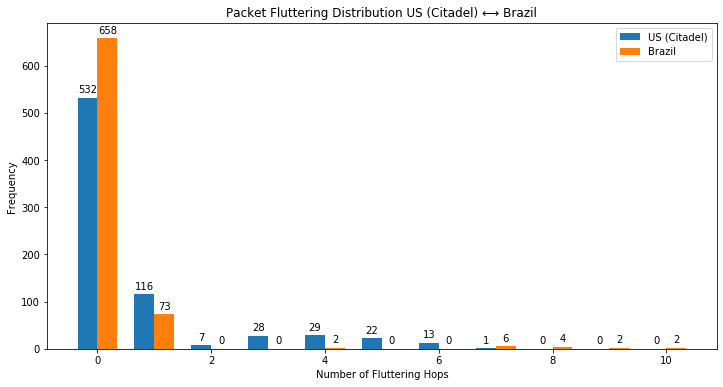

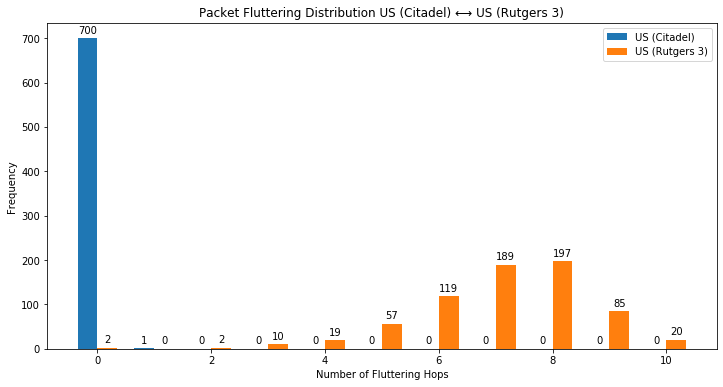

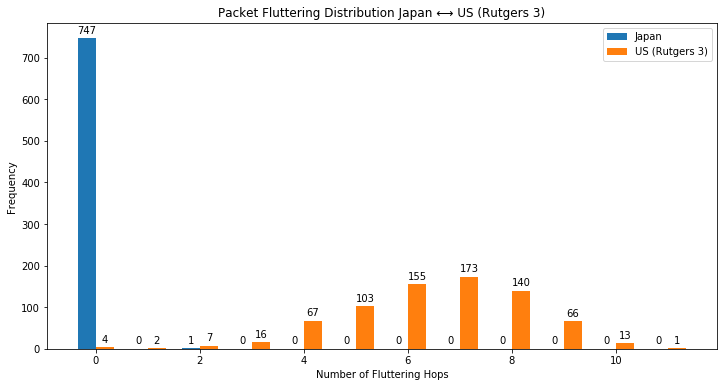

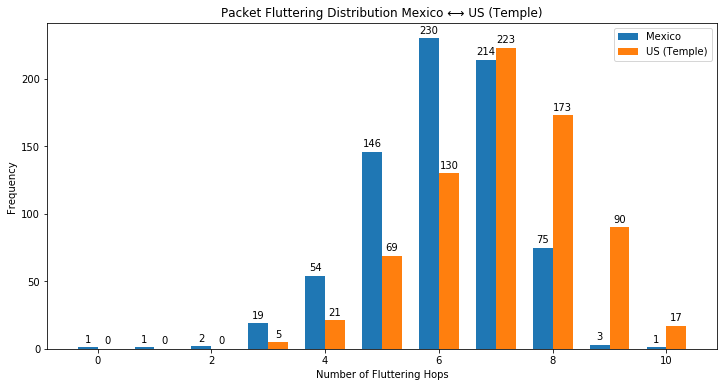

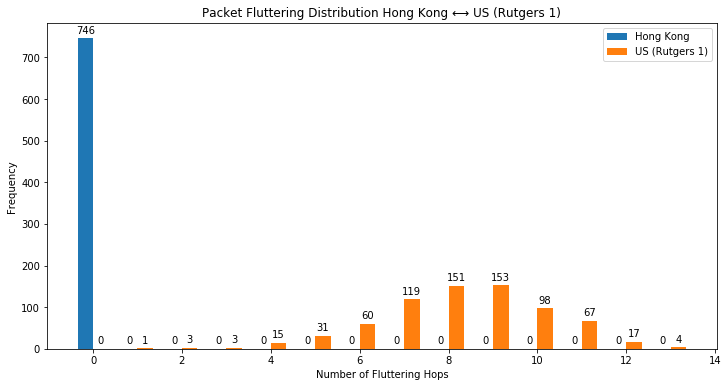

In [45]:
for title, group in df[df['measure'] == 'traceroute'].groupby(['pair']):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    flutter_values = group['Fluttering'].unique().tolist()
    flutter_values.sort()
    width = 0.35
    
    rect1 = None
    rect2 = None
    
    for i, (t, g) in enumerate(group.groupby(['src_id'])):
        counters = {k:0 for k in flutter_values}
        x = np.arange(len(counters.keys()))
        for row in g['Fluttering']:
            counters[row] += 1
        
        if i == 0:
            rect1 = ax.bar(x - width / 2, counters.values(), width, label = node_loc[t])
        else:
            rect2 = ax.bar(x + width / 2, counters.values(), width, label = node_loc[t])
            
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rect1)
    autolabel(rect2)
    ax.legend()
    ax.set_xlabel('Number of Fluttering Hops')
    ax.set_ylabel('Frequency')
#     ax.set_xticklabels(x_labels)
    ax.set_title(f'Packet Fluttering Distribution {node_pairs[set(group["pair"].values).pop()]}')